In [92]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import datetime 
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [93]:
#https://www.statsmodels.org/stable/datasets/generated/macrodata.html
# macrodata = sm.datasets.macrodata.load_pandas().data
# dt=macrodata[["year","quarter","realgdp","realcons","unemp"]]
# dt.head()

beer = pd.read_csv('beer.csv',
squeeze=True)
beer




,Unnamed: 0,Date,Tempurature_Median,Weekend,Beer_Consumption
0,0,2015-01-01,27.30,0,25.461
1,1,2015-01-02,27.02,0,28.972
2,2,2015-01-03,24.82,1,30.814
3,3,2015-01-04,23.98,1,29.799
4,4,2015-01-05,23.82,0,28.900
...,...,...,...,...,...
360,360,2015-12-27,24.00,1,32.307
361,361,2015-12-28,22.64,0,26.095
362,362,2015-12-29,21.68,0,22.309
363,363,2015-12-30,21.38,0,20.467


## 2.  The data beer.csv were collected in São Paulo,  Brazil in 2015,  in a university area,  wherethere are some parties with groups of students from 18 to 28 years of age (average).  Thedata  recorded  the  date,  median  temperature  and  daily  beer  consumption  by  liters.    Inthe  previous  homework,  you  were  asked  to  choose  a  SARIMA  model  from  the  historydata (before 2015-11-30 (included)) and forecast the beer consumption of test (2015-12-01 to2015-12-31). Use the same history and test data sets,

## (a)  Use the history data to choose a ETS model:  use m=7, run the combination of trend=(additive, multiplicative, None) and seasonal=(additive, multiplicative) (hint: 6 modelstotal), use MAPE with one-step cross validation and split=0.8.

In [94]:
# Split the data 
history = beer.loc[:'2015-12-01']
test = beer.loc['2015-12-01':]

In [96]:
history

,Unnamed: 0,Date,Tempurature_Median,Weekend,Beer_Consumption
0,0,2015-01-01,27.30,0,25.461
1,1,2015-01-02,27.02,0,28.972
2,2,2015-01-03,24.82,1,30.814
3,3,2015-01-04,23.98,1,29.799
4,4,2015-01-05,23.82,0,28.900
...,...,...,...,...,...
197,197,2015-07-17,19.14,0,22.032
198,198,2015-07-18,20.20,1,24.827
199,199,2015-07-19,19.98,1,32.473
200,200,2015-07-20,20.56,0,20.620


In [53]:
# 1. Use the history data to select ONE ETS model
def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [128]:
X= X= np.array(history['Beer_Consumption'])
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=7,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=7,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=7,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=7,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=7,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=7,damped=False)


In [130]:
mapes = [mape_1,mape_2, mape_3, mape_4, mape_5,mape_6]

for mape in mapes:
    print(mapes.index(mape), mape)
print()    
print('the minimun mape is')   
print(min(mapes))

0 0.12397351749369798
1 nan
2 0.12269949646180091
3 0.12267201203024093
4 0.12399207327386931
5 0.12272419498772115

the minimun mape is
0.12267201203024093


##  (b)  Report the model of choice from above, fit it with history data then forecast the beerconsumption  of  2015-12-01  to  2015-12-31.   Draw  the  plot  of  actual  test  values  andforecast values and report the MAPE.

## ANS --> The model of choice is mape_5 :
#### mape_4=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=7,damped=False)
#### 5 0.12267201203024093

In [131]:
model_ets=ExponentialSmoothing(history['Beer_Consumption'], trend=None, seasonal="additive", damped=False, seasonal_periods=7)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test))
pred_ets.index=test.index

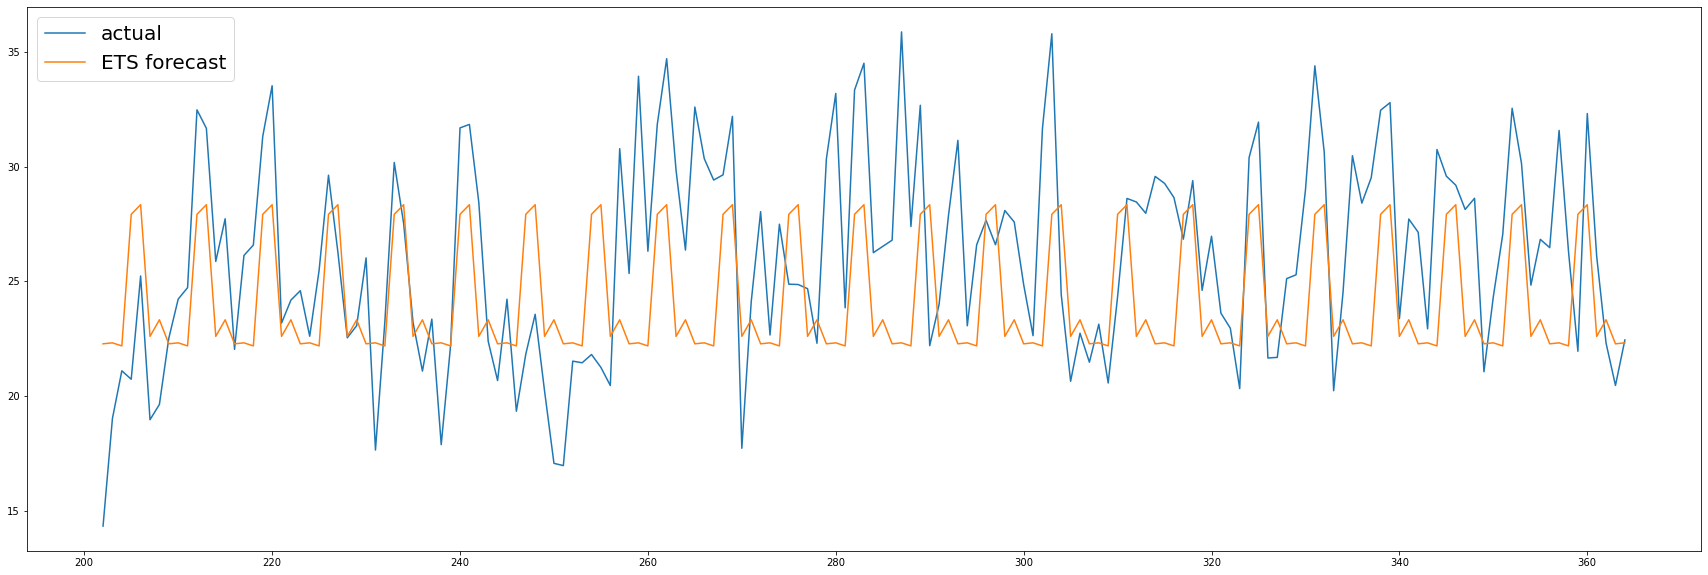

In [132]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(test['Beer_Consumption'], label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()


In [133]:
mape_test=(np.abs(np.array(test['Beer_Consumption'])-np.array(pred_ets))/np.array(test['Beer_Consumption'])).mean()
print(mape_test)

0.1383061056321716


## (c)  Fit a Prophet model with your choice of parameters (or default) on history data, thenforecast the beer consumption of 2015-12-01 to 2015-12-31. Draw the plot of actual testvalues and forecast values and report the MAPE.

In [59]:
from fbprophet import Prophet

dt=history[['Date','Beer_Consumption']]
dt=dt.rename(columns={"Date": "ds","Beer_Consumption":"y"})

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


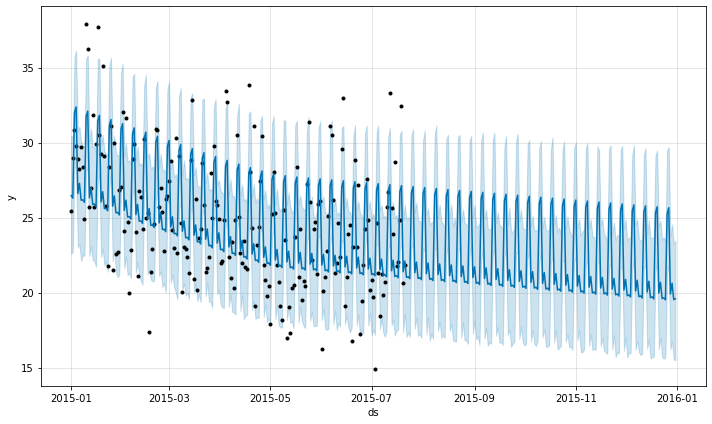

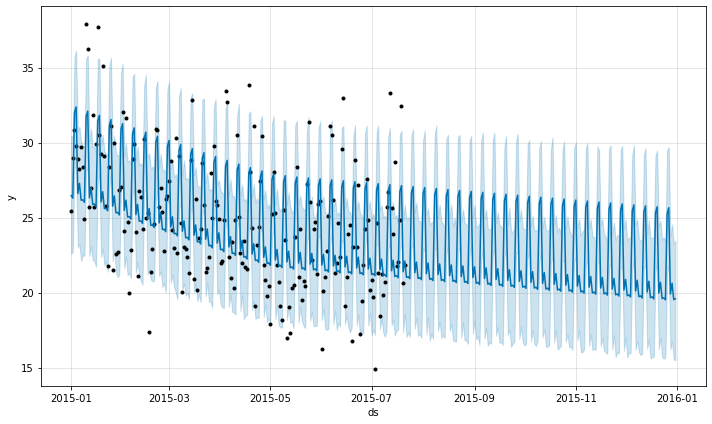

In [60]:
m = Prophet()
m.fit(dt)
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
m.plot(forecast)

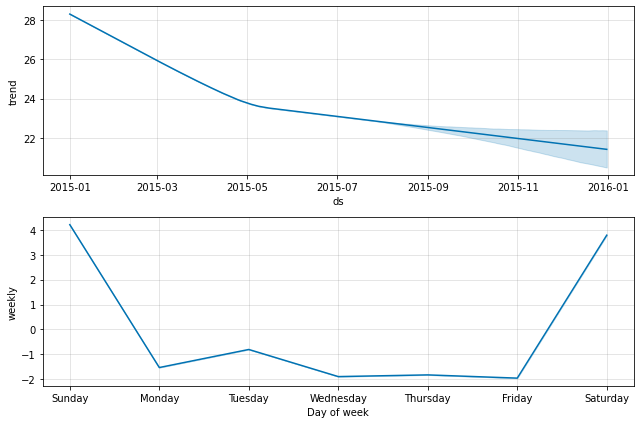

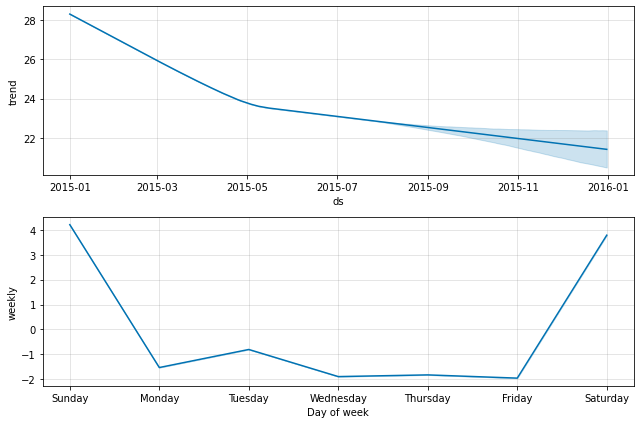

In [61]:
m.plot_components(forecast)

In [70]:
dt.shape

(202, 2)

In [71]:
pred = forecast["yhat"][202:]
pred.index=test.index

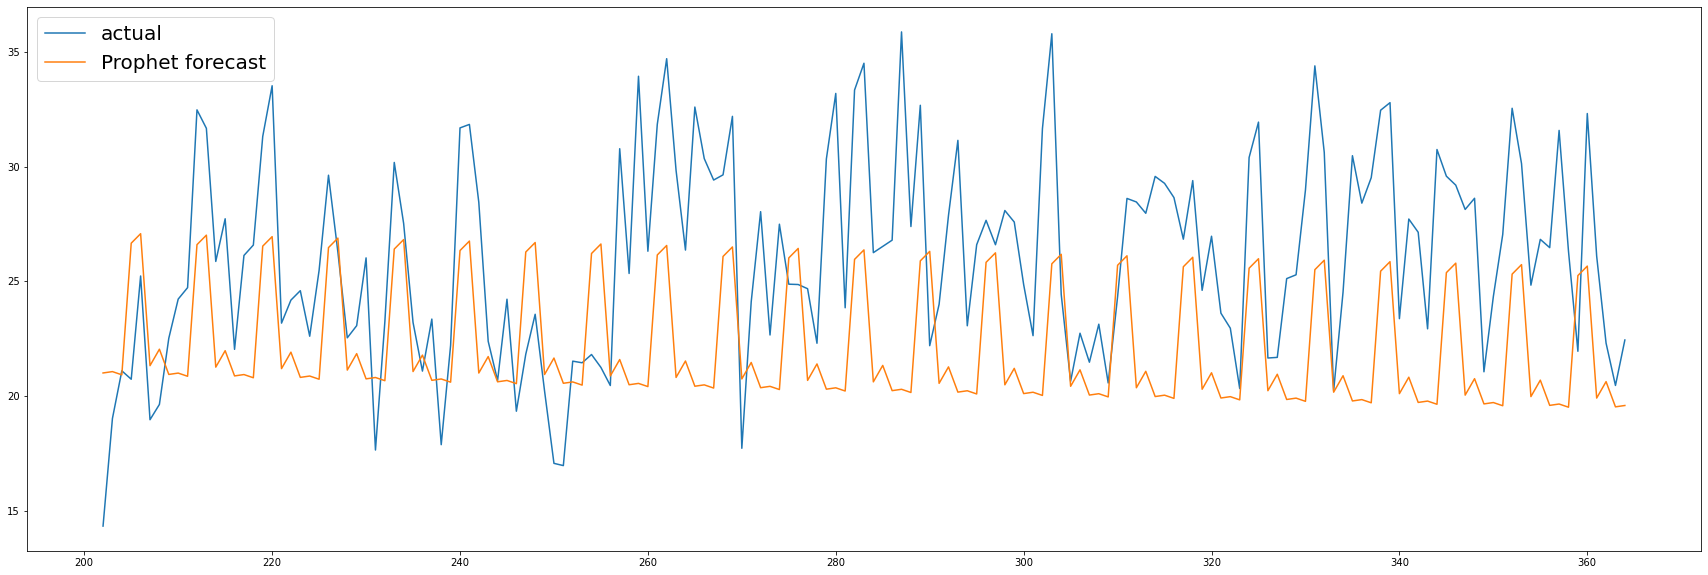

In [72]:
plt.figure(figsize=(30, 10))

plt.plot(test['Beer_Consumption'], label='actual')
plt.plot(pred, label='Prophet forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [73]:
mape_test=(np.abs(np.array(test['Beer_Consumption'])-np.array(pred))/np.array(test['Beer_Consumption'])).mean()
print(mape_test)

0.17521767583939948


##  (d)  Compare the MAPE on test data of the chosen SARIMA from homework 4, ETS andProphet. Which model is your final choice?

### ANS --> 
### Prophet-mape_test --> 0.17521767583939948
### ETS-mape_test --> 0.1383061056321716
### SARIMA-mape_test --> 

# 3.    Borrow  the  idea  of  how  we  found  a  model  for  beer  consumption  to  forecast  Tempera-ture_Median from the same dataset. Summarize a short report including:(a)  How  do  you  split  your  train(history)  for  model  fitting  and  validation,  and  test  forforecasting.(b)  Which criteria (RMSE, MAE, MAPE, BIC, and etc) and train-validation split you areusing for cross validation.(c)  Your candidate model from (S)ARIMA, ETS and Prophet family and their criteria valuefrom history set.(d)  Choose one final model, fit it with history data and predict the weather for 2015-12-01to 2015-12-31.  Draw the plot of actual test values and forecast values and report thecriteria value of your choice on test set.

##### ANS --> First the Data is splited into Training and test sets by date (until-2015-12-01) where the first part is traing set and the second part is test set. The aim is by training a model with a history (until-2015-12-01)  to predict the future weather forecast (from 2015-12-01- 2015-12-31).  The History or Training data was used to choose an ETS model based up on the possible combinations of trend and seasonality parameters. The possible combinations were additive, multiplicative, None from Trend and  additive, multiplicative from Seasonality. Additionally, seasonal periods were also taken as weekly. Then the best model was selected based upon the lowest MAPE result(lowest  sample error) which was taken from one one-step cross validation and split=0.8. The best model was fit from the history/training data and the Tempera-ture_Median was forecasted  between 2015-12-01 to 2015-12-31. The actual test values and forecast values were plotted and Mape_test was reported and compared among ETS, Prophet and SARIMA from last homework. According to the reports the candidate models have mape_tests of  0.195 for ETS, 0.396 for Prophet and 12.72 for SARIMA  and my model of choice is ETS. 

In [104]:
X= np.array(history['Tempurature_Median'])
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=7,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=7,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=7,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=7,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=7,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=7,damped=False)


In [183]:
mapes = [mape_1,mape_2, mape_3, mape_4, mape_5,mape_6]

for mape in mapes:
    print(mapes.index(mape), mape)
print()    
print('the minimun mape is')   
print(min(mapes))

0 0.8647215871891488
1 nan
2 0.8233310187181438
3 0.8232240503052565
4 0.8647208361025981
5 0.8223507318776246

the minimun mape is
0.8223507318776246


In [110]:
# Model of Choice 
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=7,damped=False)


In [113]:
model_ets=ExponentialSmoothing(history['Tempurature_Median'], trend=None, seasonal="multiplicative", damped=False, seasonal_periods=7)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test))
pred_ets.index=test.index

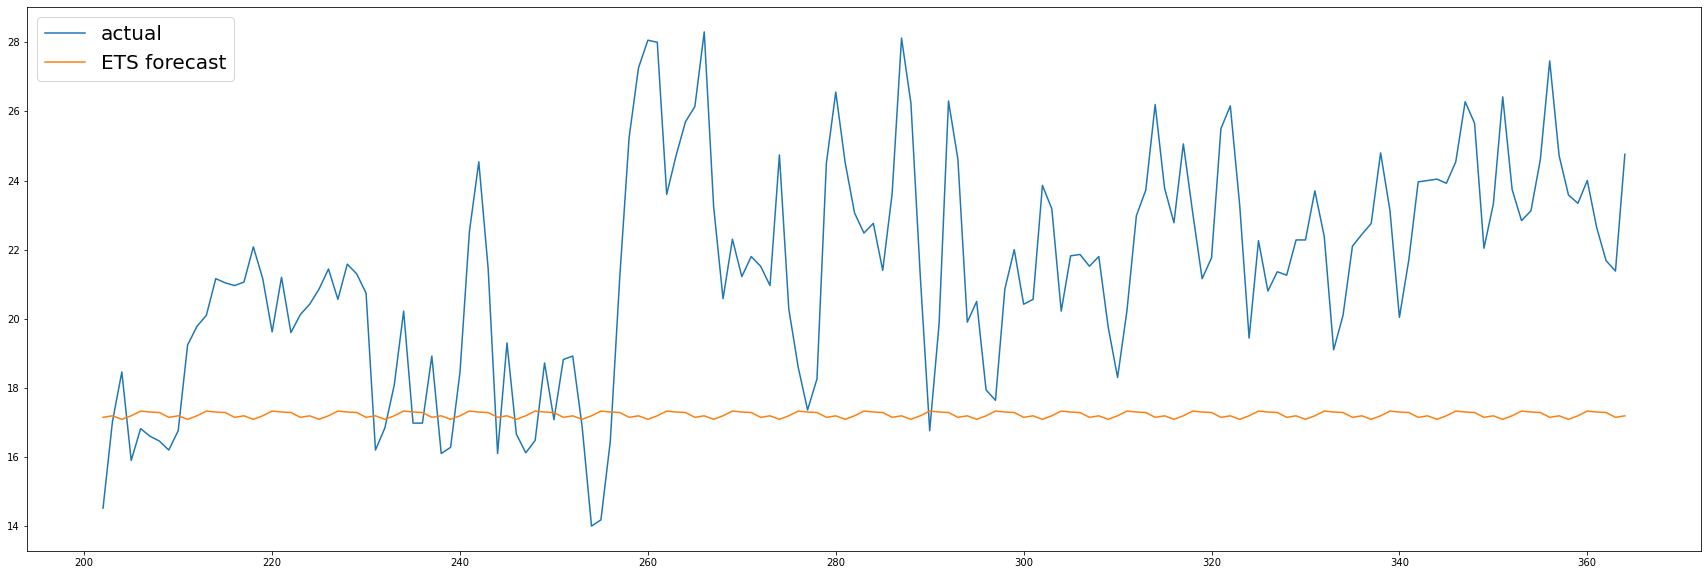

In [114]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(test['Tempurature_Median'], label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [ ]:
# Test 0.19516279872426703

In [115]:
mape_test=(np.abs(np.array(test['Tempurature_Median'])-np.array(pred_ets))/np.array(test['Tempurature_Median'])).mean()
print(mape_test)

0.19516279872426703


In [ ]:
# Prophet

In [116]:
from fbprophet import Prophet

dt=history[['Date','Tempurature_Median']]
dt=dt.rename(columns={"Date": "ds","Tempurature_Median":"y"})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


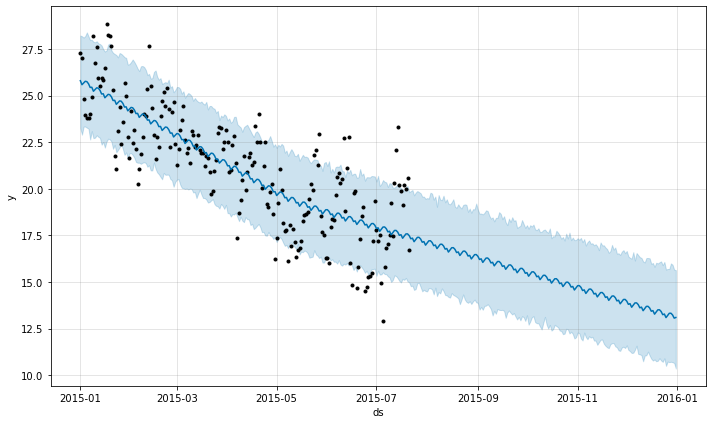

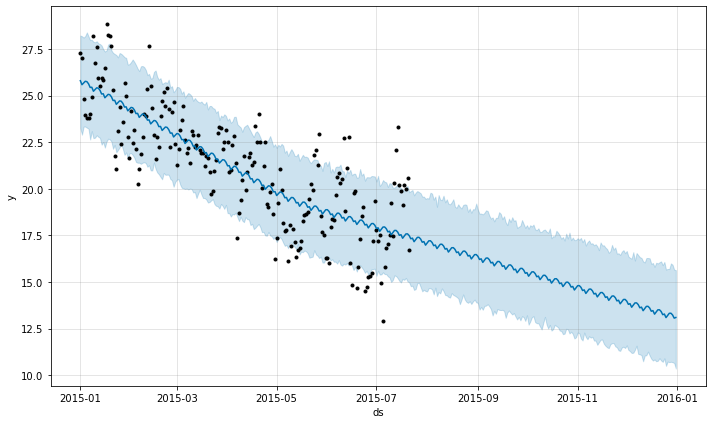

In [117]:
m = Prophet()
m.fit(dt)
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
m.plot(forecast)

In [118]:
pred = forecast["yhat"][202:]
pred.index=test.index

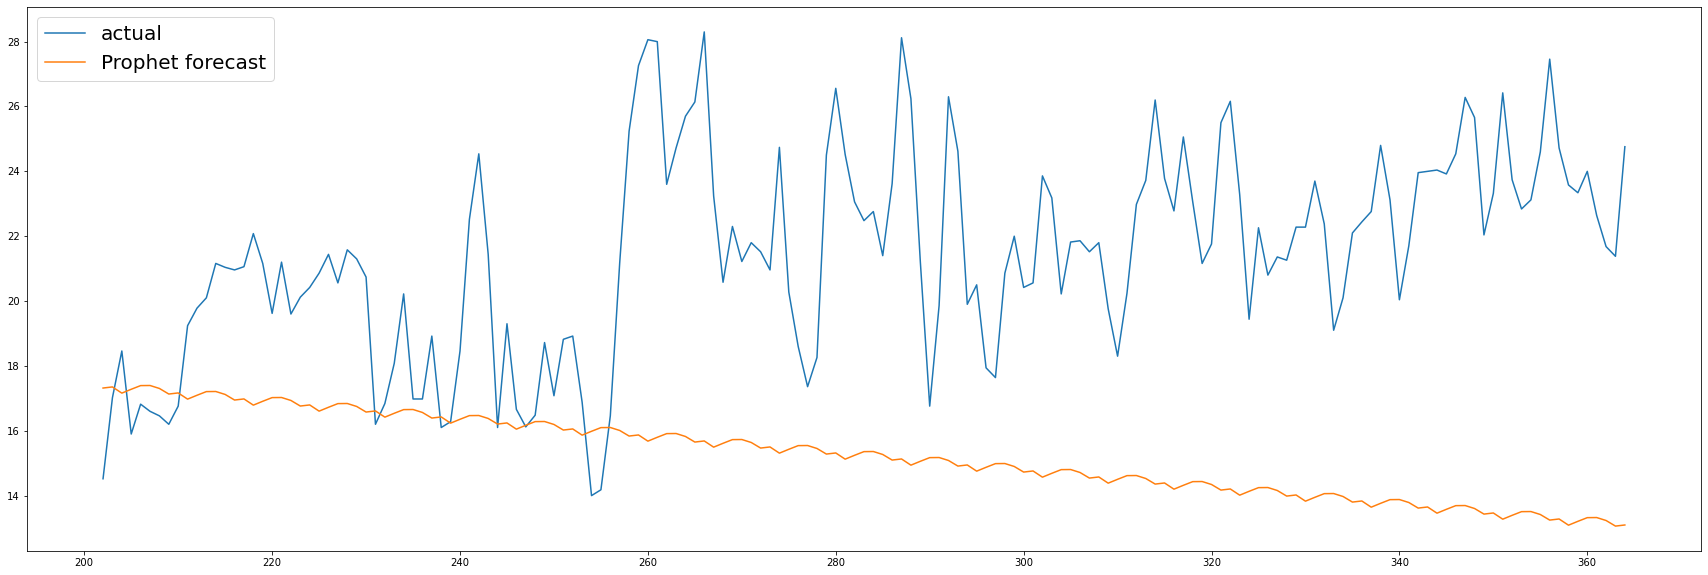

In [119]:
plt.figure(figsize=(30, 10))

plt.plot(test['Tempurature_Median'], label='actual')
plt.plot(pred, label='Prophet forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [121]:
# Test 0.39661303540921305

In [122]:
mape_test=(np.abs(np.array(test['Beer_Consumption'])-np.array(pred))/np.array(test['Beer_Consumption'])).mean()
print(mape_test)

0.39661303540921305


### 4.Does temperature affect the beer consumption?  Use temperature asan exogenous variable to fit a multivariate time series model to forecast beer consumption.Use the same history and test set from above and MAPE for evaluation. Fit a proper modelon  history  and  forecast  the  beer  consumption  for  2015-12-01  to  2015-12-31.   Report  yourMAPE of the multivariate time series model and compare it with the best univariate model you got from question 2. Which one performed better?

In [139]:
dt = beer[['Tempurature_Median','Beer_Consumption']]

In [140]:
dt

,Tempurature_Median,Beer_Consumption
0,27.30,25.461
1,27.02,28.972
2,24.82,30.814
3,23.98,29.799
4,23.82,28.900
...,...,...
360,24.00,32.307
361,22.64,26.095
362,21.68,22.309
363,21.38,20.467


In [142]:
#sarimax 

#drop na and normalize the features X for better prediction
dt=dt.dropna()
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dt)
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
X.rename(columns={0:'Tempurature_Median', 1:'Beer_Consumption'}, inplace=True)
X.head()

,Tempurature_Median,Beer_Consumption
0,0.902256,0.471221
1,0.884712,0.620031
2,0.746867,0.698101
3,0.694236,0.655082
4,0.684211,0.616979


In [143]:
#define y: "future" Beer_Consumption, here we can take the Beer_Consumption of next day
steps=-1
dt['y']=dt['Beer_Consumption'].shift(steps)
dt.tail()

,Tempurature_Median,Beer_Consumption,y
360,24.00,32.307,26.095
361,22.64,26.095,22.309
362,21.68,22.309,20.467
363,21.38,20.467,22.446
364,24.76,22.446,NaN


In [175]:
#transform y as well
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dt[['y']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [176]:
y.rename(columns={0:'Next_Beer_Consumption'}, inplace= True)
y.index=dt.index
y.head(5)

,Next_Beer_Consumption
0,0.620031
1,0.698101
2,0.655082
3,0.616979
4,0.588073


In [180]:
#split train and test
period= 164

train_X, train_y = X[:-period].dropna(), y[:-period].dropna()
test_X, test_y = X[-period:].dropna(), y[-period:].dropna()
train_X = train_X .set_index(train_y.index)


(     Tempurature_Median  Beer_Consumption
 0              0.902256          0.471221
 1              0.884712          0.620031
 2              0.746867          0.698101
 3              0.694236          0.655082
 4              0.684211          0.616979
 ..                  ...               ...
 196            0.437343          0.313851
 197            0.390977          0.325888
 198            0.457393          0.444350
 199            0.443609          0.768416
 200            0.479950          0.266042
 
 [201 rows x 2 columns],
      Next_Beer_Consumption
 0                 0.620031
 1                 0.698101
 2                 0.655082
 3                 0.616979
 4                 0.588073
 ..                     ...
 196               0.325888
 197               0.444350
 198               0.768416
 199               0.266042
 200               0.317115
 
 [201 rows x 1 columns])

In [182]:
X= np.array(train_y)
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=7,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=7,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=7,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=7,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=7,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=7,damped=False)


In [184]:
mapes = [mape_1,mape_2, mape_3, mape_4, mape_5,mape_6]

for mape in mapes:
    print(mapes.index(mape), mape)
print()    
print('the minimun mape is')   
print(min(mapes))

0 0.8647215871891488
1 nan
2 0.8233310187181438
3 0.8232240503052565
4 0.8647208361025981
5 0.8223507318776246

the minimun mape is
0.8223507318776246


## Best model 
## mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=7,damped=False)
## the minimun mape is
## 0.8223507318776246

In [205]:
model_ets=ExponentialSmoothing(np.array(train_y), trend=None, seasonal="multiplicative", damped=False, seasonal_periods=7)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(test_y))
# pred_ets

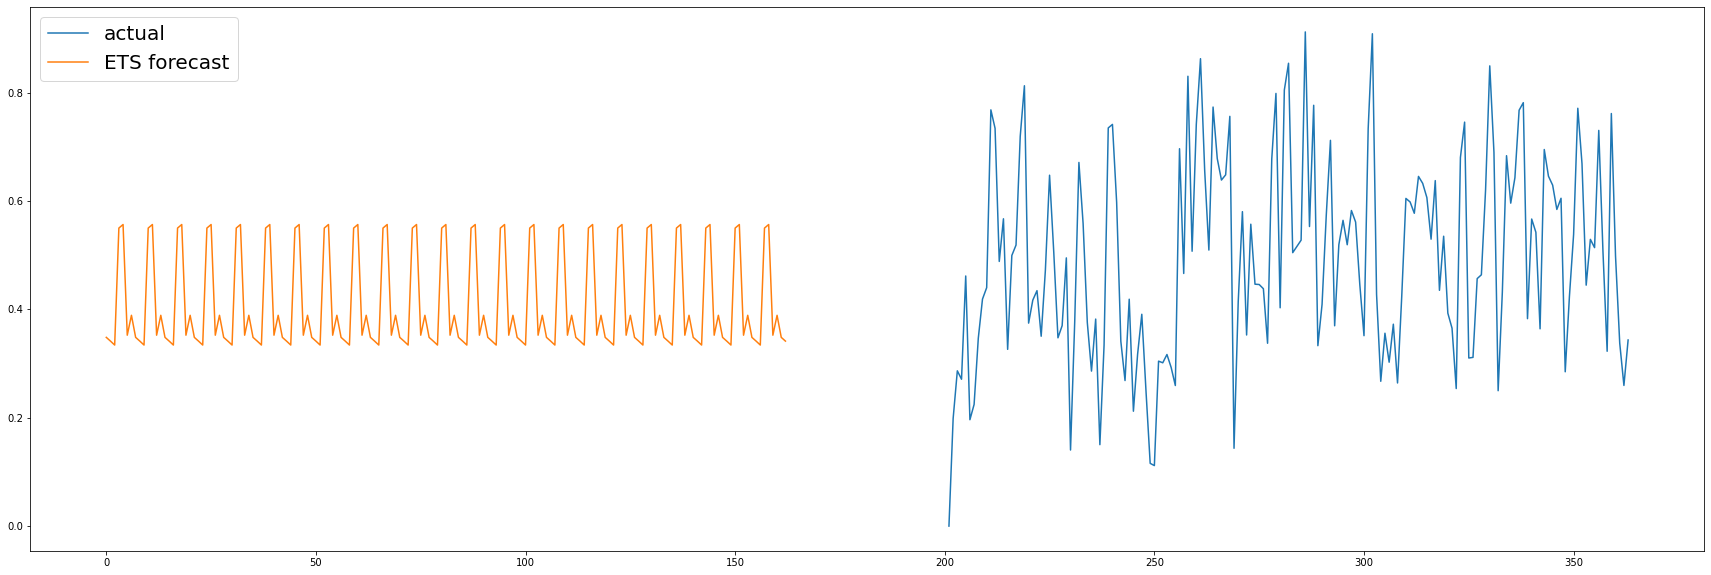

In [206]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(test_y, label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [207]:
mape_test=(np.abs(np.array(test_y)-np.array(pred_ets))/np.array(test_y)).mean()
print(mape_test)

inf
